## Installing Required Python Packages

Note: run the following cell once. 

In [1]:
# !pip install -r requirements.txt

## Importing essential Python Packages

In [40]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
from scipy.optimize import minimize
from astropy.io import fits
from astropy import wcs
from matplotlib import cm
import pickle
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

# %matplotlib notebook
# %matplotlib notebook

`sbfTools` hold all the auxiliary functions we use in this notebook.
Make sure that `sbfTools.py` is in located in the same folder as this notebook.

In [41]:
# make sure 
from sbfTools import *

In [42]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [43]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
configFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/config/'


In [44]:
obj = SBFobject("u03396", inFolder=inFolder, config=configFolder, force_new=False)

backing up log.temp

cp ./log.tmp ./log.tmp.back


In [45]:
obj.uuid

'58b2aebb7ea6'

In [46]:
obj.params

{'backSextract': {'threshold': 0.08},
 'naiveSextract': {'minarea': 200.0, 'threshold': 3.0, 'smooth': 5.0},
 'basic_elliprof': {'r0': 9.0,
  'c_kron': 2.5,
  'sky_factor': 0.9,
  'k_ellipse': 15.0,
  'option': 'COS3X=0'},
 'second_elliprof': {'r0': 26.0,
  'c_kron': 4.2,
  'sky_factor': 0.83,
  'k_ellipse': 19.0,
  'option': 'COS3X=0',
  'minarea': 704.0,
  'threshold': 4.0,
  'smooth': 3.5,
  'renuc': 2.0}}

In [47]:
s = obj.slider_back_threshold()

widgets.HBox(s)

Back Median: 2363.80
Back Mean: 2365.13
Back Stdev: 83.73
fig. name:  Outputs_u03396/u03396_58b2aebb7ea6/u03396_initial_back.png


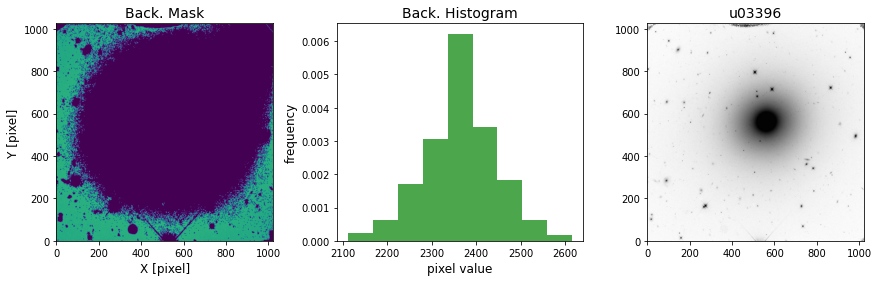

In [48]:
%matplotlib inline

_ = obj.plot_back_mask()

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

In [49]:
widget = obj.slider_naive_sex()

widgets.HBox(widget)

fig. name:  Outputs_u03396/u03396_58b2aebb7ea6/u03396_initial_mask.png


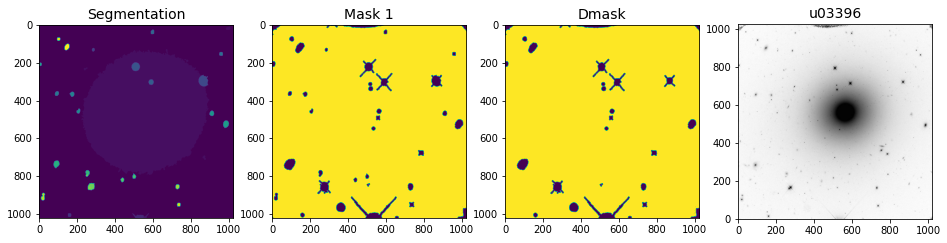

In [50]:
%matplotlib inline

_ = obj.plot_naivesex()

## Running Elliprof

Here, we run `elliprof` for the firt time. The initial mask that was generated above (e.g. mask=1) is utilized here and `model=0` is created. Usually, the Kron_radius factor is set to a value greater than 2 and smaller than 4.
The main goal is to generate very crude model.

- `r0`: Inner radius to fit
- `r1`: Outer radius to fit, i.e. `obj.outerR(c_kron)`, where `outerR` takes the Kron radius factor and converts it to number of pixels
- `c_kron`: Kron radius factor
- `sky`: sky value, which is roughly about 90% of the median of the values of the background pixels. *Note:* The sky level would be fine tuned later.
- `k`: A factor to determine the number of fitting radii, i.e. `nr=(r1-r0)/k`
- `options`: Any other that `elliprof` accepts. 


**Note:** The following sliders control parameters for the inital run of elliprof

In [51]:
widget = obj.basic_elliprof_widget()

widgets.VBox(widget)

N_cross: 0
r0: 9
r1: 216
nr: 14
sky: 2127
fig. name:  Outputs_u03396/u03396_58b2aebb7ea6//u03396_basic_model.png


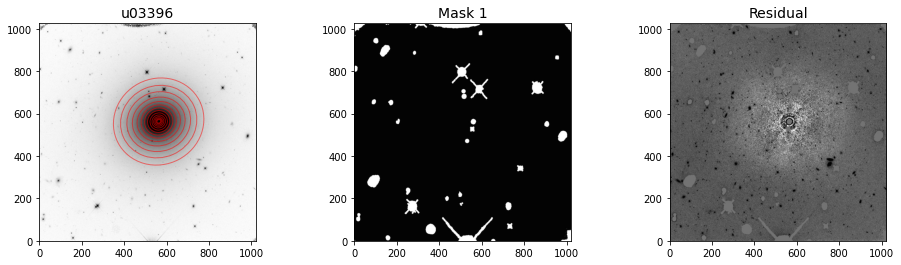

In [52]:
%matplotlib inline

_ = obj.basic_elliprof()

## Second round of elliprof

Here, we use the primary model that we generated in the previous cell to cover the masked regions.
Then we run SExtractor for additional mask. The residuals of model=0 is used to create another mask. The initial mask can be further augmented with the mask we generate here.

- `model=0`: initial profile model from the previous cell. The masked regions are replaced by this model
- `model_mask`: the model that is used to patch the masked regions

**Top**
- Left: Red ellipse displays the galaxy border defined by Kron radius

**Notes:**

- Left Slider: Parameter to creat elliprof models

- Right Slider: Parameters to run SExtractor on the residual image for the purpose of generating additonal mask, i.e. `mask=2`

- Sometimes, one has to iteratively gnerate `mask=2` and combine it with `mask1`. The resutls would be always stored in `mask=1`.

In [53]:
s1, s2 = obj.second_elliprof_widget()

box1 = widgets.VBox(s1)
box2 = widgets.VBox(s2)

widgets.HBox([box1,box2])


<IPython.core.display.Javascript object>


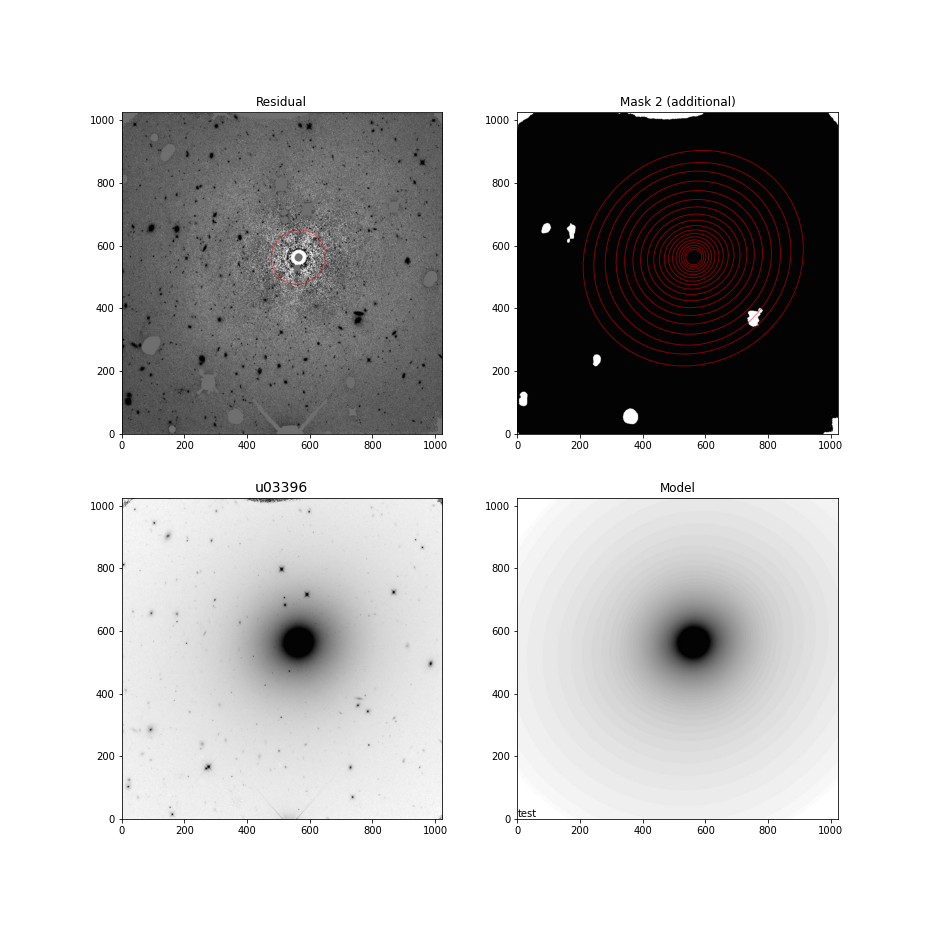

fig. name:  Outputs_u03396/u03396_58b2aebb7ea6//u03396_initial_model.png


Checkbox(value=False, description='Combine Mask')

In [59]:
%matplotlib notebook

_ = obj.second_elliprof()

checkbox = widgets.Checkbox(description='Combine Mask', value = False)
checkbox

**Note:** Use the above checkbox if you want to combine masks. This box always gets deactived when a new additiona mask (`mask=2`) is generated.

## Mask augmentation

If we are happy with the additional mask we found above, we add these two masks and update the primary mask.
After updating the mask (`mask=1`), the previous cell can be iteratively executed with updating the mask multiple time until we are satisfied.

In [55]:
# combining mask1 and mask2 ----> mask1
if checkbox.value==True:
    obj.addMasks(maskList=[1,2], mask=1)

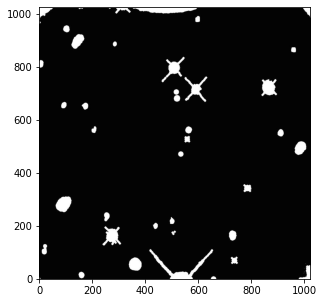

In [58]:
%matplotlib inline

plt.figure(figsize=(5,5))
plt.subplot(111)
ax = plt.gca()
obj.tv_mask(mask=1, ax=ax)

pngName = obj.objRoot+'/'+obj.name+'_combined_mask.png'
plt.savefig(pngName)

## Updating the background level

Here, we update the background factor, and regenerate the `elliprof` model until the median of the residual value of the background pixels is roughly zero. 

In [30]:
## Updating background level?

option = obj.params["second_elliprof"]["option"]
c_kron = obj.params["second_elliprof"]["c_kron"]
k = obj.params["second_elliprof"]["k_ellipse"]

r0         = obj.params["second_elliprof"]["r0"] 
r1         = obj.outerR(c_kron)      
nr         = int(np.round((r1-r0)/k))
initial_sky_factor = obj.params["second_elliprof"]["sky_factor"]

# model #: the elliprof model id
optimized_sky_factor = obj.optimize_sky_factor(initial_sky_factor, r0, r1, nr, options=option, model=999)   

print("Optimized sky factor: ", "%.3f"%optimized_sky_factor)


Optimized sky factor:  0.950


### Optimizing Sky Factor  with different input parameters

The following block runs the optimziation code using various input parameters chosen randomly 
and each time returns the optimzized `sky_factor`

In [31]:
n_iterations = 10
max_ellise_crossing = 3

if False:
    
    i = 1

    print("i, r0, r1, nr, n_cross, initial_sky_factor, final_sky_factor")

    while i<=n_iterations:

        c_kron = obj.params["second_elliprof"]["c_kron"] 
        option = obj.params["second_elliprof"]["option"] 

        r0 = np.random.randint(8,15)
        r1 = np.random.randint(obj.outerR(c_kron*0.9) , obj.outerR(c_kron*2))
        k = np.random.randint(8,15)
        nr = int(np.round(r1/k))
        sf = np.random.uniform(0.75,0.95)      # initial sky_factor to begin with

        if i==1:
            model_mask=0
        else:
            model_mask = 1000-i+1

        sky_factor = obj.optimize_sky_factor(sf, r0, r1, nr, options=options, model_mask=model_mask,
                                         model=1000-i, verbose=False)


        if sky_factor!=0:

            ## how many ellipses cross each other
            n_cross = Xellipses(obj.list_ellipses(model=1000-i))

            if n_cross<=max_ellise_crossing:
                print(i, r0, r1, nr, n_cross, '%.3f'%sf, '%.3f'%sky_factor)
                i+=1


#### Decide what `sky_factor` to use !

In [32]:
sky_factor = optimized_sky_factor
# sky_factor = initial_sky_factor

## Plotting the light profile

So far, we found the optimum **sky factor** and the `initial mask`.
`r0` and `r1` has been chosen by user iteratively to get reasonable results.

Now, we visualize the light profile of galaxy and the residual image for the final check.

In the following plot we have
- **Left:** The light profile. Each point show the surface brightness on an ellipse. The horizontal axis is scaled to accommodate the `r^1/4` form. Open black circles represent the region used to find the red dotted line in a least square process. This linear fit is extrapolated towards larger radii to examine the behavior of the outer region. If a galaxy follows a pure `r^1/4`, all outer point must fall on the fitted line.

- **Right:** The residual image, which is generated by subtracting the primary model from the galaxy image. Red concentric ellipse are the ellipses. Yellow circles represent the region used for the linear fit in the left panel.

No. of crossing ellipses: 0
fig. name:  Outputs_u03396/u03396_58b2aebb7ea6/u03396_light_profile.png
profile table name:  Outputs_u03396/u03396_58b2aebb7ea6/u03396_light_profile.csv
   Rmaj      x0      y0        I0   alpha  ellip   I(3x)   A(3x)   I(4x)  \
0  26.0  562.84  562.55  117483.7  112.88  0.068  0.0011  115.37  0.0021   
1  32.2  562.82  562.53   80813.6  115.89  0.053  0.0007   82.11  0.0015   
2  39.4  562.79  562.49   53953.5  124.44  0.041  0.0012   35.58  0.0034   
3  47.8  562.87  562.44   36751.7  123.51  0.041  0.0015   19.48  0.0053   
4  57.5  562.82  562.39   26033.7  119.40  0.047  0.0030   52.37  0.0061   

   A(4x)  slope  
0  32.58  -1.31  
1  16.24  -1.89  
2   2.86  -2.06  
3  69.08  -2.01  
4  75.92  -1.92  


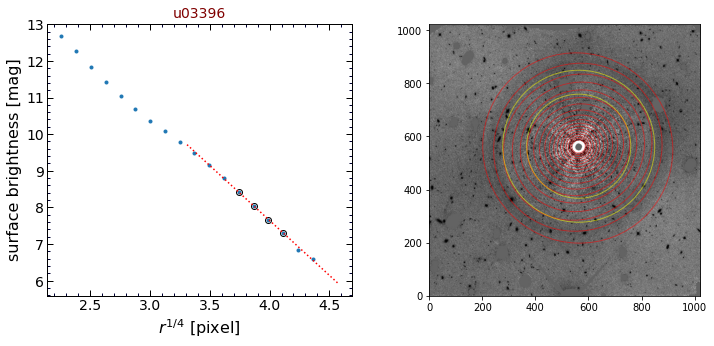

In [33]:
sky = int(sky_factor*obj.sky_med)

_ = obj.plot_profile(sky_factor, r0, r1, nr, options=option)

## Visualizing the background histogram

In the following cell, the distribution of the residual values of the background pixels is plotted.
In the case of having a good model and sky value, the median/mean values of the residuals should be close to zero.

**Note:** Sometimes, very bright objects must be masked out manually to makes sure that there no contamination from such objects, otherwise the background must have been over-estimated.

Back Median: -67.62
Back Mean: -66.64
Back Stdev: 82.54
fig. name:  Outputs_u03396/u03396_58b2aebb7ea6/u03396_updated_back.png
New potential sky factor: 0.921


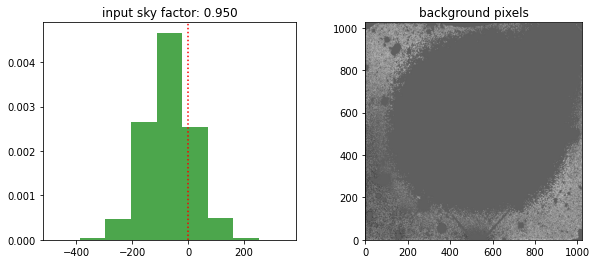

In [34]:
_ = obj.plot_back_histogram(sky_factor)

## Saving the model

Here, we store all metadata and other information on disk to be used in other steps.

In [35]:
df = obj.save_log(sky_factor)

df

Log File:  Outputs_u03396/u03396_58b2aebb7ea6/../u03396_model_log.csv


,index,value,description
0,index,value,description
1,uuid,58b2aebb7ea6,Unique Identifier Code
2,User,Ehsan,User Name
3,Time,2022-07-20 12:28:35.806706,Modification Time
4,Name,u03396,Object Name
5,X_pixels,1022,X-dimension of image [pixel]
6,Y_pixels,1025,Y-dimension of image [pixel]
7,R_max,458,maximum horizontal/vertical distance from cent...
8,X0,563.268,Object Center X0 [pixel]
9,Y0,563.234,Object Center Y0 [pixel]
